# WHEAT DISEASE CLASSIFICATION
## Importing important Libraries


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications import VGG19
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model
from glob import glob


## Connecting to Gdrive & importing dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
dataset = "/gdrive/My Drive/Tarp Dataset/"
label = "lb.pickle"

### Inputting the folders name as labels

In [4]:
LABELS = set(["Crown and Root Rot","Healthy Wheat", "Leaf Rust", "Loose Smut"])

In [5]:
imagePaths = list(paths.list_images(dataset))
print(imagePaths)
data = []
labels = []

['/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/01511.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/01901.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/07461.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/03931.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/07281.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/00601.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/03861.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/00691.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/06651.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/00591.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/03991.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/01271.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/00621.jpeg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/04421.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/04101.jpg', '/gdrive/My Drive/Tarp Dataset/Crown and Root Rot/07871.jpg'

In [6]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    if label not in LABELS:
        continue
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)


In [7]:
data = np.array(data)
labels = np.array(labels)

if labels.size > 0:
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
else:
    print("Error: Labels array is empty or contains no samples.")

# Data Augumentation

In [8]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

## Spiltting the dataset

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.30, stratify=labels, random_state=42)

In [11]:
trainX.shape

(2342, 224, 224, 3)

In [12]:
headmodel = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [13]:
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
moodel = Model(inputs=headmodel.input, outputs=model)

In [14]:
for layer in headmodel.layers:
    layer.trainable = False

In [15]:
moodel.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

In [16]:
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=50)

Epoch 1/50
36/36 [==============================] - 59s 1s/step - loss: 2.4051 - accuracy: 0.5549 - val_loss: 0.9999 - val_accuracy: 0.7312
Epoch 2/50
36/36 [==============================] - 33s 910ms/step - loss: 1.0246 - accuracy: 0.6765 - val_loss: 0.7403 - val_accuracy: 0.7792
Epoch 3/50
36/36 [==============================] - 33s 909ms/step - loss: 0.7757 - accuracy: 0.7151 - val_loss: 0.6882 - val_accuracy: 0.7708
Epoch 4/50
36/36 [==============================] - 32s 899ms/step - loss: 0.6720 - accuracy: 0.7564 - val_loss: 0.7092 - val_accuracy: 0.7646
Epoch 5/50
36/36 [==============================] - 33s 903ms/step - loss: 0.5871 - accuracy: 0.7845 - val_loss: 0.5948 - val_accuracy: 0.7917
Epoch 6/50
36/36 [==============================] - 33s 917ms/step - loss: 0.5569 - accuracy: 0.7792 - val_loss: 0.5242 - val_accuracy: 0.8458
Epoch 7/50
36/36 [==============================] - 33s 903ms/step - loss: 0.5175 - accuracy: 0.8060 - val_loss: 0.5146 - val_accuracy: 0.8438
Ep

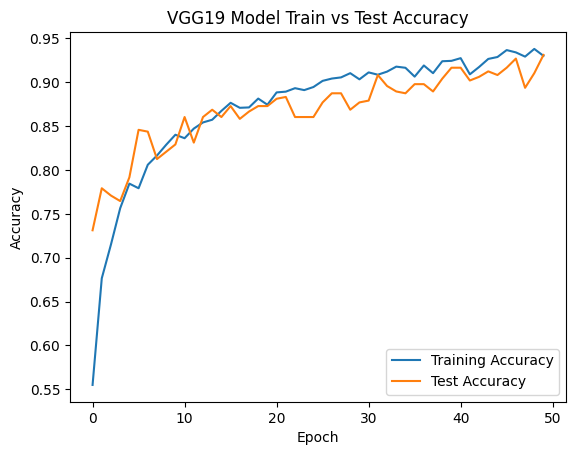

<Figure size 640x480 with 0 Axes>

In [17]:
N = 50
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig("acc_plot.png")


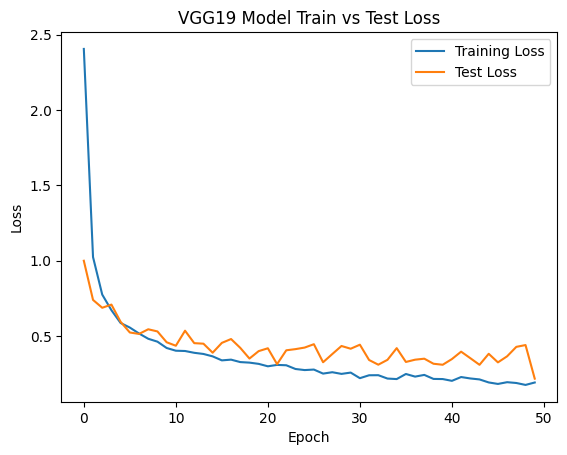

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig("loss_plot.png")


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate predictions on test data
predictions = moodel.predict(testX, batch_size=64)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(testY, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)


16/16 [==============================] - 11s 703ms/step
Confusion Matrix:
[[278  16   4   9]
 [ 15 315   2  12]
 [  0   3  70   2]
 [  8  17   9 245]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       307
           1       0.90      0.92      0.91       344
           2       0.82      0.93      0.87        75
           3       0.91      0.88      0.90       279

    accuracy                           0.90      1005
   macro avg       0.89      0.91      0.90      1005
weighted avg       0.90      0.90      0.90      1005



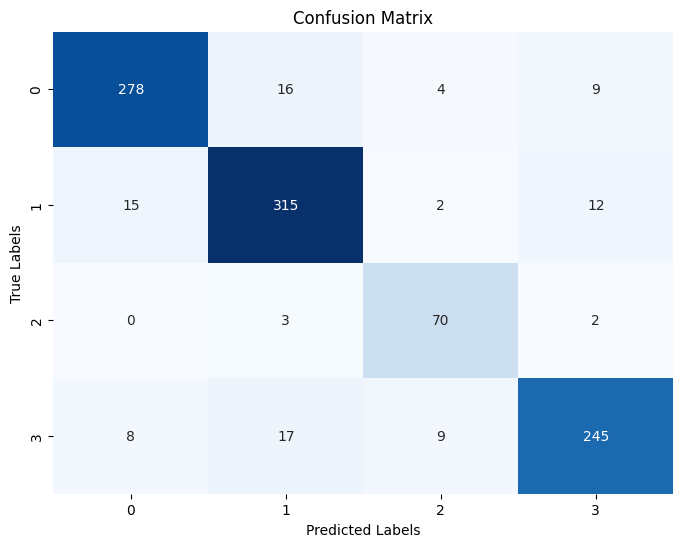

In [20]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# save the model to disk
moodel.save("model.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Testing**

In [22]:
from keras.models import load_model
import imutils
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
from collections import deque
import pickle

In [23]:
import cv2
import pickle
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

model_path = "/content/model.h5"
input_path = "/content/lolr(8).JPG"
label_file = "lb.pickle"

# Load the pre-trained model and label binarizer
moodel = load_model(model_path)
lb = pickle.loads(open("label", "rb").read())

mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input_path)

(W, H) = (None, None)

while True:
    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean

    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)

    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]

    text = "PREDICTION: {}".format(label.upper())


     # Put prediction text below the input image
    text_x = int(W / 2 - len(text) * 6)
    text_y = int(H * 1.1)

    # Draw a rectangle behind the text for better visibility
    cv2.rectangle(output, (0, text_y - 25), (W, text_y + 10), (0, 0, 0), -1)
    cv2.putText(output, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (200, 255, 155), 2)

    cv2_imshow(output)
    print(text)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

vs.release()
cv2.destroyAllWindows()
